# Introduction

This project will focus on exploring the capabilities of Bayesian optimization, specifically employing BayBE, in the discovery of novel corrosion inhibitors for materials design. Initially, we will work with a randomly chosen subset from a comprehensive database of electrochemical responses of small organic molecules. Our goal is to assess how Bayesian optimization can speed up the screening process across the design space to identify promising compounds. We will compare different strategies for incorporating alloy information, while optimizing the experimental parameters with respect to the inhibitive performance of the screened compounds.

# Initizalization

Loading libraries and data files:

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from baybe import Campaign
from baybe.objective import Objective
from baybe.parameters import NumericalDiscreteParameter, SubstanceParameter
from baybe.recommenders import RandomRecommender, TwoPhaseMetaRecommender
from baybe.searchspace import SearchSpace
from baybe.simulation import simulate_scenarios
from baybe.targets import NumericalTarget

df_AA2024 = pd.read_excel('data/averaged_filtered_AA2024.xlsx')
df_AA1000 = pd.read_excel('data/averaged_filtered_AA1000.xlsx')
df_Al = pd.read_excel('data/averaged_filtered_Al.xlsx')

df_active = df_AA1000
df_active

,SMILES,Time_h,pH,Inhib_Concentrat_M,Salt_Concentrat_M,Efficiency
0,C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O,0.0,2.0,5.000000e-07,2,53.85
1,C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O,0.0,2.0,1.000000e-06,2,58.55
2,C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O,0.0,2.0,5.000000e-06,2,67.40
3,C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O,0.0,2.0,1.000000e-05,2,86.65
4,C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O,0.0,2.0,5.000000e-05,2,73.90
...,...,...,...,...,...,...
303,S=c1sc2c([nH]1)cccc2,384.0,-0.6,4.200000e-03,0,70.60
304,S=c1sc2c([nH]1)cccc2,384.0,-0.6,5.300000e-03,0,79.77
305,S=c1sc2c([nH]1)cccc2,384.0,-0.6,6.500000e-03,0,76.72
306,S=c1sc2c([nH]1)cccc2,384.0,-0.6,7.500000e-03,0,75.44


In [115]:
# SMOKE_TEST = "SMOKE_TEST" in os.environ

# N_MC_ITERATIONS = 2 if SMOKE_TEST else 5
# N_DOE_ITERATIONS = 2 if SMOKE_TEST else 5
# BATCH_SIZE = 1 if SMOKE_TEST else 3

In [116]:
lookup = df_active

In [117]:
# chemical space dictionary
unique_SMILES = df_active.SMILES.unique()

def list_to_dict(input_list):
    return {item: item for item in input_list}

smiles_dict =list_to_dict(unique_SMILES)

In [118]:
# parameters

# mordred
parameters_mordred = [
NumericalDiscreteParameter(
    name="Time_h",
    values=df_active['Time_h'].unique(),
    # tolerance = 0.004, assume certain experimental noise for each parameter measurement?
),
NumericalDiscreteParameter(
    name="pH",
    values=df_active['pH'].unique(),
    # tolerance = 0.004
    ),  
NumericalDiscreteParameter( # Set this as continuous, the values seem quite small?
    name="Inhib_Concentrat_M",
    values= df_active['Inhib_Concentrat_M'].unique(),
    # tolerance = 0.004
    ),
NumericalDiscreteParameter(
    name="Salt_Concentrat_M",
    values=df_active['Salt_Concentrat_M'].unique(),
    # tolerance = 0.004
    ),
SubstanceParameter(
    name="SMILES",
    data=smiles_dict,
    encoding="MORDRED",  # optional
    decorrelate=0.7,  # optional
    )        
    ]

# morgan fingerprints
parameters_morgan_fp = [
NumericalDiscreteParameter(
    name="Time_h",
    values=df_active['Time_h'].unique(),
    # tolerance = 0.004, assume certain experimental noise for each parameter measurement?
),
NumericalDiscreteParameter(
    name="pH",
    values=df_active['pH'].unique(),
    # tolerance = 0.004
    ),  
NumericalDiscreteParameter( # Set this as continuous, the values seem quite small?
    name="Inhib_Concentrat_M",
    values= df_active['Inhib_Concentrat_M'].unique(),
    # tolerance = 0.004
    ),
NumericalDiscreteParameter(
    name="Salt_Concentrat_M",
    values=df_active['Salt_Concentrat_M'].unique(),
    # tolerance = 0.004
    ),
SubstanceParameter(
    name="SMILES",
    data=smiles_dict,
    encoding="MORGAN_FP",  # optional
    decorrelate=0.7,  # optional
    )        
    ]

# rdkit
parameters_rdkit = [
NumericalDiscreteParameter(
    name="Time_h",
    values=df_active['Time_h'].unique(),
    # tolerance = 0.004, assume certain experimental noise for each parameter measurement?
),
NumericalDiscreteParameter(
    name="pH",
    values=df_active['pH'].unique(),
    # tolerance = 0.004
    ),  
NumericalDiscreteParameter( # Set this as continuous, the values seem quite small?
    name="Inhib_Concentrat_M",
    values= df_active['Inhib_Concentrat_M'].unique(),
    # tolerance = 0.004
    ),
NumericalDiscreteParameter(
    name="Salt_Concentrat_M",
    values=df_active['Salt_Concentrat_M'].unique(),
    # tolerance = 0.004
    ),
SubstanceParameter(
    name="SMILES",
    data=smiles_dict,
    encoding="RDKIT",  # optional
    decorrelate=0.7,  # optional
    )        
    ]


In [119]:
df_no_target = lookup.drop('Efficiency', axis=1)

# searchspace = SearchSpace.from_dataframe(df = df_no_target, parameters=parameters)
# print('Print test 1')
# objective = Objective(
#     mode="SINGLE", targets=[NumericalTarget(name="Efficiency", mode="MAX")]
# )


searchspace_mordred = SearchSpace.from_dataframe(df = df_no_target, parameters=parameters_mordred)


searchspace_morgan = SearchSpace.from_dataframe(df = df_no_target, parameters=parameters_morgan_fp)


searchspace_rdkit = SearchSpace.from_dataframe(df = df_no_target, parameters=parameters_rdkit)


objective = Objective(
    mode="SINGLE", targets=[NumericalTarget(name="Efficiency", mode="MAX")]
)


In [120]:
searchspace_rdkit

SearchSpace(discrete=SubspaceDiscrete(parameters=[NumericalDiscreteParameter(name='Time_h', encoding=None, _values=[0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 24.0, 48.0, 72.0, 96.0, 120.0, 144.0, 168.0, 192.0, 240.0, 288.0, 336.0, 384.0], tolerance=0.0), NumericalDiscreteParameter(name='pH', encoding=None, _values=[-0.6, -0.4771212547196624, -0.3979400086720376, -0.3010299956639812, -0.1760912590556812, 0.0, 0.3, 0.45, 1.0, 2.0, 7.0, 13.0], tolerance=0.0), NumericalDiscreteParameter(name='Inhib_Concentrat_M', encoding=None, _values=[1e-07, 5e-07, 1e-06, 2e-06, 4e-06, 5e-06, 6e-06, 8e-06, 1e-05, 1.2e-05, 2e-05, 4e-05, 5e-05, 6e-05, 8e-05, 0.0001, 0.0001958863858961802, 0.0002, 0.0003, 0.0003566333808844508, 0.0003917727717923605, 0.0004, 0.0005, 0.0005876591576885406, 0.0006, 0.0007132667617689017, 0.0007835455435847209, 0.0008, 0.0009794319294809011, 0.001, 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016, 0.001783166904422254, 0.0018, 0.0019, 0.002, 0.

In [121]:
campaign_mordred = Campaign(searchspace=searchspace_mordred, objective=objective)
campaign_morgan = Campaign(searchspace=searchspace_morgan, objective=objective)
campaign_rdkit = Campaign(searchspace=searchspace_rdkit, objective=objective)

campaign_rand_mordred = Campaign(
    searchspace=searchspace_mordred,
    recommender=TwoPhaseMetaRecommender(recommender=RandomRecommender()),
    objective=objective,
)
campaign_rand_morgan = Campaign(
    searchspace=searchspace_morgan,
    recommender=TwoPhaseMetaRecommender(recommender=RandomRecommender()),
    objective=objective,
)
campaign_rand_rdkit = Campaign(
    searchspace=searchspace_rdkit,
    recommender=TwoPhaseMetaRecommender(recommender=RandomRecommender()),
    objective=objective,
)

In [122]:
scenarios = {"Mordred": campaign_mordred, #"Random": campaign_rand_mordred,
             "Morgan": campaign_morgan, #"Morgan Random": campaign_rand_morgan,
             "RDKIT": campaign_rdkit, "Random": campaign_rand_rdkit
             }

In [128]:
N_MC_ITERATIONS = 10
N_DOE_ITERATIONS = 50
BATCH_SIZE = 1

results = simulate_scenarios(
    scenarios,
    lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
    impute_mode="best",
)

  0%|          | 0/40 [00:00<?, ?it/s]/home/vscode/.local/lib/python3.10/site-packages/botorch/models/transforms/outcome.py:304: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  stdvs = Y.std(dim=-2, keepdim=True)
/home/vscode/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
  2%|2         | 1/40 [00:14<09:26, 14.52s/it]/home/vscode/.local/lib/python3.10/site-packages/botorch/models/transforms/outcome.py:304: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (inp

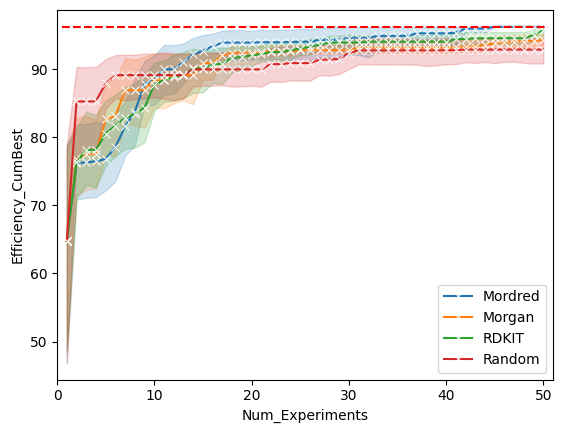

In [129]:
max_yield = lookup["Efficiency"].max()
# plot_results = results[results['Scenario'].isin(['Mordred', 'Morgan', 'RDKIT'])]

sns.lineplot(
    data=results, x="Num_Experiments", y="Efficiency_CumBest", hue="Scenario", marker="x"
)
plt.plot([0.5, N_DOE_ITERATIONS+0.5], [max_yield, max_yield], "--r")
plt.legend(loc="lower right")
import matplotlib.pyplot as plt

plt.xlim(0, N_DOE_ITERATIONS+1)
plt.savefig("./AA1000_simulation_10MC_50exp_1batch.png")

In [125]:
results

,Scenario,Random_Seed,Iteration,Num_Experiments,Efficiency_Measurements,Efficiency_IterBest,Efficiency_CumBest
0,Mordred,1337,0,1,[71.38],71.380000,71.380
1,Mordred,1337,1,2,[83.742],83.742000,83.742
2,Mordred,1337,2,3,[67.0],67.000000,83.742
3,Mordred,1337,3,4,[67.04],67.040000,83.742
4,Mordred,1337,4,5,[47.0],47.000000,83.742
...,...,...,...,...,...,...,...
395,Random,1346,5,6,[71.72],71.720000,92.500
396,Random,1346,6,7,[68.00666666666666],68.006667,92.500
397,Random,1346,7,8,[6.08],6.080000,92.500
398,Random,1346,8,9,[90.0],90.000000,92.500


# Non - simulation stuff

In [6]:
# targets 
from baybe.targets import NumericalTarget
from baybe.objective import Objective

target = NumericalTarget(
    name="Efficiency",
    mode="MAX",
)
objective = Objective(mode="SINGLE", targets=[target])

In [7]:
# parameters
parameters = [
NumericalDiscreteParameter(
    name="Time_h",
    values=df_active['Time_h'].unique(),
    # tolerance = 0.004, assume certain experimental noise for each parameter measurement?
),
NumericalDiscreteParameter(
    name="pH",
    values=df_active['pH'].unique(),
    # tolerance = 0.004
    ),  
NumericalDiscreteParameter( # Set this as continuous, the values seem quite small?
    name="Inhib_Concentrat_M",
    values= df_active['Inhib_Concentrat_M'].unique(),
    # tolerance = 0.004
    ),
NumericalDiscreteParameter(
    name="Salt_Concentrat_M",
    values=df_active['Salt_Concentrat_M'].unique(),
    # tolerance = 0.004
    ),
SubstanceParameter(
    name="SMILES",
    data=smiles_dict,
    encoding="MORDRED",  # optional
    decorrelate=0.7,  # optional
    )        
    ]
parameters

[NumericalDiscreteParameter(name='Time_h', encoding=None, _values=[0.5, 1.0, 2.0, 3.0, 6.0, 24.0, 48.0, 72.0, 96.0, 120.0, 144.0, 168.0, 192.0, 240.0, 288.0, 336.0, 360.0, 384.0, 432.0, 480.0, 528.0, 576.0, 600.0, 624.0, 672.0], tolerance=0.0),
 NumericalDiscreteParameter(name='pH', encoding=None, _values=[0.0, 3.3, 4.0, 4.4, 5.4, 5.5, 5.6, 7.0, 10.0], tolerance=0.0),
 NumericalDiscreteParameter(name='Inhib_Concentrat_M', encoding=None, _values=[1e-05, 5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0008, 0.001, 0.0012, 0.0018, 0.0024, 0.003, 0.005, 0.01, 0.011, 0.021, 0.022, 0.031, 0.033, 0.042, 0.044, 0.05, 0.1], tolerance=0.0),
 NumericalDiscreteParameter(name='Salt_Concentrat_M', encoding=None, _values=[0.0, 0.01, 0.05, 0.1, 0.5, 0.6], tolerance=0.0),
 SubstanceParameter(name='SMILES', data={'COCCOC(=O)OCSc1nc2c(s1)cccc2': 'COCCOC(=O)OCSc1nc2c(s1)cccc2', 'Cc1ccc(c(c1)n1nc2c(n1)cccc2)O': 'Cc1ccc(c(c1)n1nc2c(n1)cccc2)O', 'Clc1ccc(cc1)CC[C@](C(C)(C)C)(Cn1cncn1)O': 'Clc1ccc(cc

In [9]:
# define search space
df_no_target = lookup.drop('Efficiency', axis=1)

searchspace = SearchSpace.from_dataframe(df = df_no_target, parameters=parameters)
searchspace

SearchSpace(discrete=SubspaceDiscrete(parameters=[NumericalDiscreteParameter(name='Time_h', encoding=None, _values=[0.5, 1.0, 2.0, 3.0, 6.0, 24.0, 48.0, 72.0, 96.0, 120.0, 144.0, 168.0, 192.0, 240.0, 288.0, 336.0, 360.0, 384.0, 432.0, 480.0, 528.0, 576.0, 600.0, 624.0, 672.0], tolerance=0.0), NumericalDiscreteParameter(name='pH', encoding=None, _values=[0.0, 3.3, 4.0, 4.4, 5.4, 5.5, 5.6, 7.0, 10.0], tolerance=0.0), NumericalDiscreteParameter(name='Inhib_Concentrat_M', encoding=None, _values=[1e-05, 5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0008, 0.001, 0.0012, 0.0018, 0.0024, 0.003, 0.005, 0.01, 0.011, 0.021, 0.022, 0.031, 0.033, 0.042, 0.044, 0.05, 0.1], tolerance=0.0), NumericalDiscreteParameter(name='Salt_Concentrat_M', encoding=None, _values=[0.0, 0.01, 0.05, 0.1, 0.5, 0.6], tolerance=0.0), SubstanceParameter(name='SMILES', data={'COCCOC(=O)OCSc1nc2c(s1)cccc2': 'COCCOC(=O)OCSc1nc2c(s1)cccc2', 'Cc1ccc(c(c1)n1nc2c(n1)cccc2)O': 'Cc1ccc(c(c1)n1nc2c(n1)cccc2)O', 'Clc1ccc(

In [10]:
# recommenders
from baybe.recommenders import RandomRecommender, SequentialGreedyRecommender
from baybe.surrogates import GaussianProcessSurrogate

SURROGATE_MODEL = GaussianProcessSurrogate()
ACQ_FUNCTION = "qEI" # q-Expected Improvement, only q-fuctions are available for batch_size > 1

seq_greedy_recommender = SequentialGreedyRecommender(
        surrogate_model=SURROGATE_MODEL,
        acquisition_function_cls=ACQ_FUNCTION,
        hybrid_sampler="Farthest", # find more details in the documentation
        sampling_percentage=0.3, # should be relatively low
        allow_repeated_recommendations=False,
        allow_recommending_already_measured=False,
    )

In [11]:
# campaign strategy
from baybe.strategies import TwoPhaseStrategy
from baybe import Campaign

strategy = TwoPhaseStrategy(
    initial_recommender = RandomRecommender(),  # Initial recommender
    # Doesn't matter since I already have training data, BUT CAN BE USED FOR BENCHMARKING
    recommender = seq_greedy_recommender,  # Bayesian model-based optimization
    switch_after=1  # Switch to the model-based recommender after 1 batches = immediately
)

# setup campaign
campaign = Campaign(searchspace, objective, strategy)
print(campaign)

Campaign
         
 Meta Data
 Batches Done: 0
 Fits Done: 0
 
 Search Space
          
  Search Space Type: DISCRETE
  
  Discrete Search Space
               
   Discrete Parameters
                    Name                        Type  Num_Values                   Encoding
   0              Time_h  NumericalDiscreteParameter          25                       None
   1                  pH  NumericalDiscreteParameter           9                       None
   2  Inhib_Concentrat_M  NumericalDiscreteParameter          25                       None
   3   Salt_Concentrat_M  NumericalDiscreteParameter           6                       None
   4              SMILES          SubstanceParameter         123  SubstanceEncoding.MORDRED
               
   Experimental Representation
        Time_h    pH  ...  Salt_Concentrat_M                                 SMILES
   0      24.0   4.0  ...               0.10           COCCOC(=O)OCSc1nc2c(s1)cccc2
   1      24.0  10.0  ...               0.10     

/home/vscode/.local/lib/python3.10/site-packages/baybe/strategies/deprecation.py:26: DeprecationWarning: 'TwoPhaseStrategy' is deprecated and will be removed in a future version. Please use 'recommenders.TwoPhaseMetaRecommender' class instead.
  warnings.warn(


In [12]:
# recommendations 
new_rec = campaign.recommend(batch_size=3) # TEST with different batch sizes for optimal performance
print("\n\nRecommended experiments: ")
print(new_rec.to_markdown())



Recommended experiments: 
|     |   Time_h |   pH |   Inhib_Concentrat_M |   Salt_Concentrat_M | SMILES                                                               |
|----:|---------:|-----:|---------------------:|--------------------:|:---------------------------------------------------------------------|
| 484 |    480   |    7 |                0.031 |                0.05 | C(C(C(C(C(C(=O)[O-])O)O)O)O)O.C(C(C(C(C(C(=O)[O-])O)O)O)O)O.[Fe+2]   |
| 227 |      0.5 |    7 |                0.01  |                0.6  | C1=CC(=C(C=C1SSC2=CC(=C(C=C2)[N+](=O)[O-])C(=O)O)C(=O)O)[N+](=O)[O-] |
| 394 |    144   |    7 |                1e-05 |                0.01 | [N+](=O)([O-])[O-].[N+](=O)([O-])[O-].[N+](=O)([O-])[O-].[Ce+3]      |


In [13]:
new_rec["Efficiency"] = [79.8, 54.1, 59.4]
campaign.add_measurements(new_rec)

Input row with index 227 has multiple matches with the search space. This could indicate that something went wrong. Matching only first occurrence.


In [14]:
campaign

Campaign(searchspace=SearchSpace(discrete=SubspaceDiscrete(parameters=[NumericalDiscreteParameter(name='Time_h', encoding=None, _values=[0.5, 1.0, 2.0, 3.0, 6.0, 24.0, 48.0, 72.0, 96.0, 120.0, 144.0, 168.0, 192.0, 240.0, 288.0, 336.0, 360.0, 384.0, 432.0, 480.0, 528.0, 576.0, 600.0, 624.0, 672.0], tolerance=0.0), NumericalDiscreteParameter(name='pH', encoding=None, _values=[0.0, 3.3, 4.0, 4.4, 5.4, 5.5, 5.6, 7.0, 10.0], tolerance=0.0), NumericalDiscreteParameter(name='Inhib_Concentrat_M', encoding=None, _values=[1e-05, 5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0008, 0.001, 0.0012, 0.0018, 0.0024, 0.003, 0.005, 0.01, 0.011, 0.021, 0.022, 0.031, 0.033, 0.042, 0.044, 0.05, 0.1], tolerance=0.0), NumericalDiscreteParameter(name='Salt_Concentrat_M', encoding=None, _values=[0.0, 0.01, 0.05, 0.1, 0.5, 0.6], tolerance=0.0), SubstanceParameter(name='SMILES', data={'COCCOC(=O)OCSc1nc2c(s1)cccc2': 'COCCOC(=O)OCSc1nc2c(s1)cccc2', 'Cc1ccc(c(c1)n1nc2c(n1)cccc2)O': 'Cc1ccc(c(c1)n1nc2c(n

In [15]:
second_rec = campaign.recommend(batch_size=3) # TEST with different batch sizes for optimal performance
print("\n\nRecommended experiments: ")
print(second_rec.to_markdown())



Recommended experiments: 
|   index |   Time_h |   pH |   Inhib_Concentrat_M |   Salt_Concentrat_M | SMILES                                                 |
|--------:|---------:|-----:|---------------------:|--------------------:|:-------------------------------------------------------|
|     194 |       24 |   10 |               0.001  |                 0.1 | C1N2CN3CN1CN(C2)C3                                     |
|     297 |       24 |    0 |               0.0004 |                 0   | CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C(=O)O)C  |
|     300 |       24 |    0 |               0.0004 |                 0   | CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C(=O)O)C  |
|     303 |       24 |    0 |               0.0004 |                 0   | CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C(=O)O)C  |
|     306 |       24 |    0 |               0.0004 |                 0   | CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C(=O)O)C  |
|     586 |        3 |    0 |               0.00

# Data Analysis

# Bayesian Optimization

## Search Space

## Objective

## Recommender

# Benchmarking

# Transfer Learning